### 1. Data Loading & Exploration

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedStratifiedKFold, learning_curve
from sklearn.metrics import (
    confusion_matrix, classification_report, precision_recall_curve, auc,
    f1_score, precision_score, recall_score, roc_auc_score
)

from sklearn.metrics import precision_recall_curve, auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
import warnings
from sklearn.feature_selection import SelectKBest, f_classif

warnings.filterwarnings('ignore')

# Set visualization style
sns.set_palette("viridis")
plt.style.use('ggplot')

# Load data
data = pd.read_csv("creditcard.csv")
print("First 5 rows of the dataset:")
print(data.head())
print("\nDataset shape (rows, columns):", data.shape)
print("\nColumn names:", list(data.columns))
print("\nDataset information:")
data.info()
print("\nDescriptive statistics:")
print(data.describe())


First 5 rows of the dataset:
   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

   

### 2. Visual Data Analysis

Fraud vs Non-Fraud statistics (heatmaps)

Class distribution (pie and count plot)

Correlation heatmap

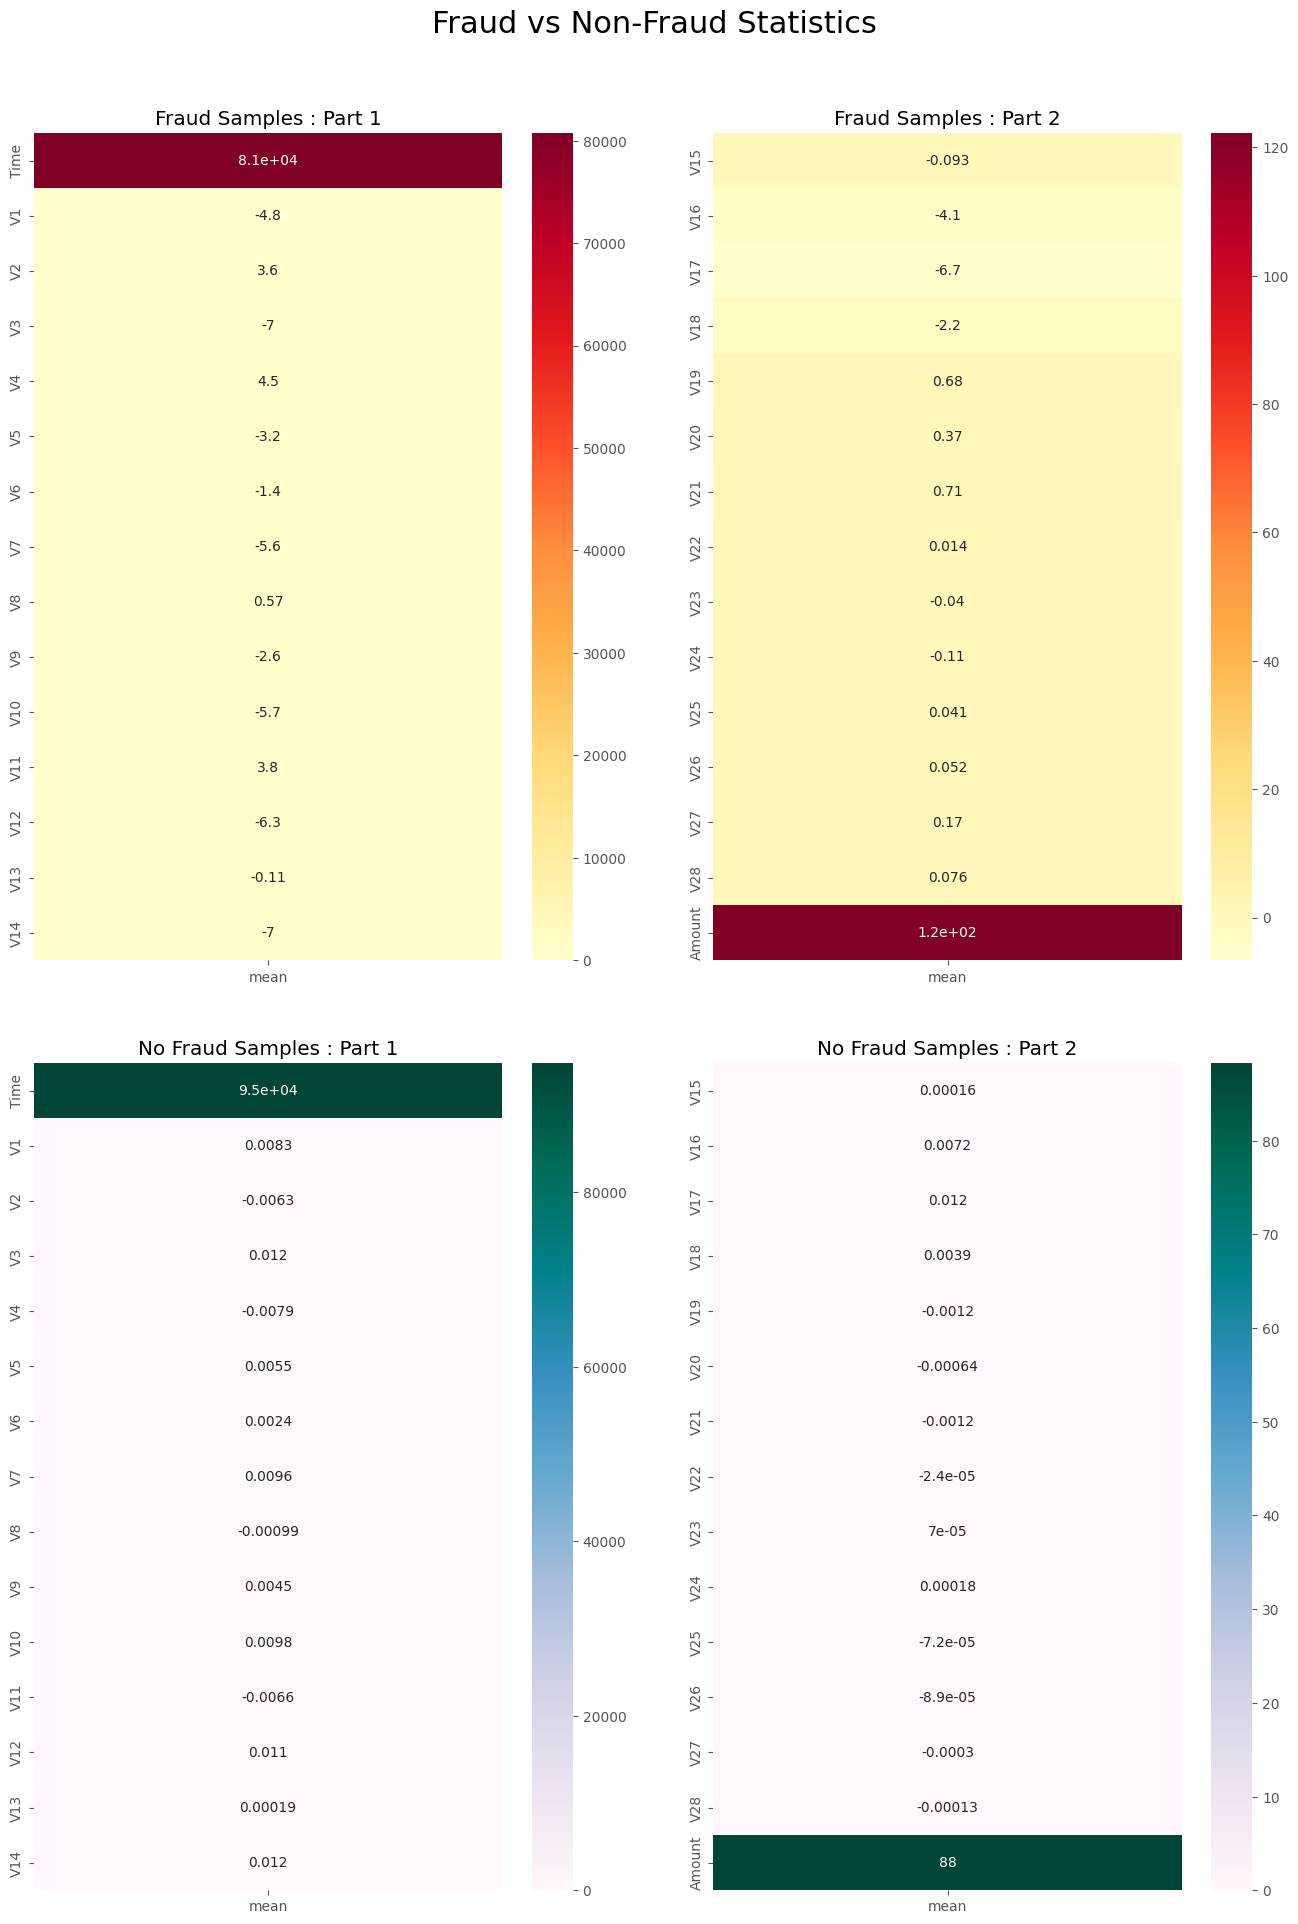

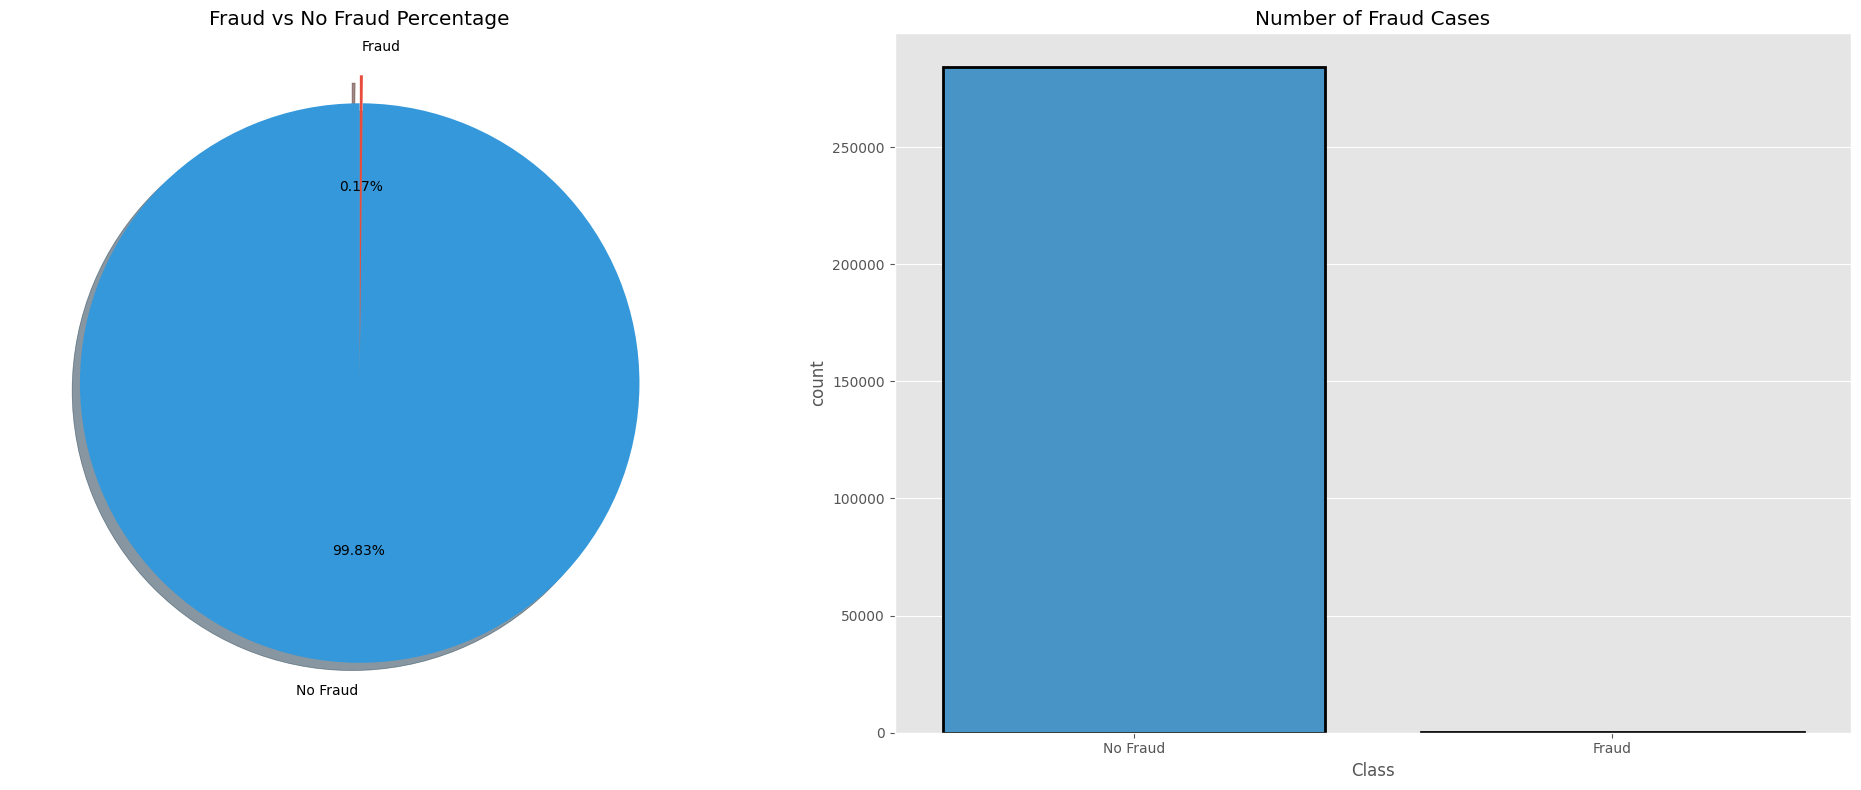

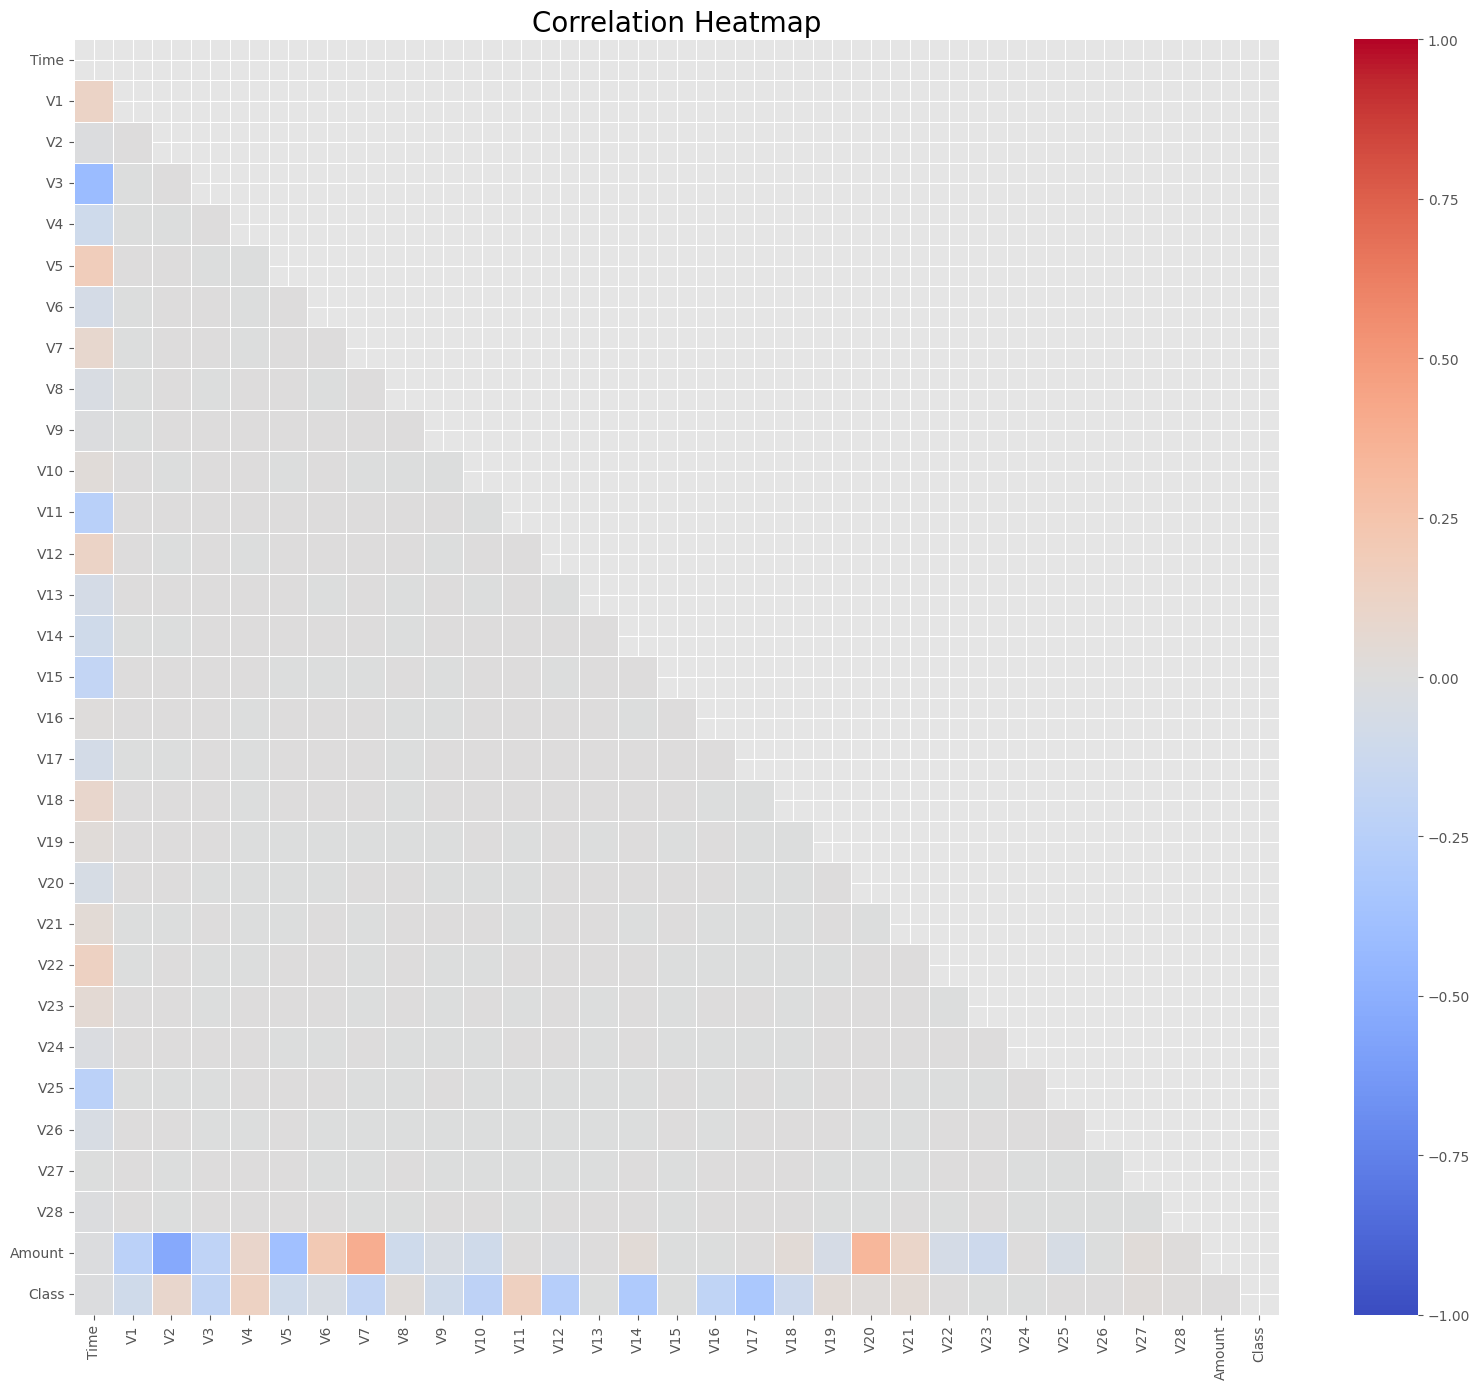

In [3]:
# Fraud vs Non-Fraud statistics
fraud = data[data['Class'] == 1].describe().T
nofraud = data[data['Class'] == 0].describe().T

fig, ax = plt.subplots(2, 2, figsize=(14, 20))
sns.heatmap(fraud[['mean']][:15], annot=True, cmap='YlOrRd', ax=ax[0, 0])
ax[0, 0].set_title('Fraud Samples : Part 1')
sns.heatmap(fraud[['mean']][15:30], annot=True, cmap='YlOrRd', ax=ax[0, 1])
ax[0, 1].set_title('Fraud Samples : Part 2')
sns.heatmap(nofraud[['mean']][:15], annot=True, cmap='PuBuGn', ax=ax[1, 0])
ax[1, 0].set_title('No Fraud Samples : Part 1')
sns.heatmap(nofraud[['mean']][15:30], annot=True, cmap='PuBuGn', ax=ax[1, 1])
ax[1, 1].set_title('No Fraud Samples : Part 2')
fig.suptitle('Fraud vs Non-Fraud Statistics', fontsize=22)
plt.tight_layout(pad=4)
plt.show()

# Class distribution
fraud_percent = len(data[data['Class'] == 1]) / len(data) * 100
nofraud_percent = len(data[data['Class'] == 0]) / len(data) * 100
plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.pie([nofraud_percent, fraud_percent], labels=['No Fraud', 'Fraud'], autopct='%1.2f%%',
        startangle=90, colors=['#3498db', '#e74c3c'], explode=(0, 0.1), shadow=True)
plt.title('Fraud vs No Fraud Percentage')
plt.subplot(1, 2, 2)
ax = sns.countplot(x='Class', data=data, palette=[
                   '#3498db', '#e74c3c'], edgecolor='black', linewidth=2)
ax.set_xticklabels(['No Fraud', 'Fraud'])
plt.title('Number of Fraud Cases')
plt.tight_layout()
plt.show()

# Correlation heatmap
plt.figure(figsize=(16, 14))
correlation_matrix = data.corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, cmap='coolwarm',
            annot=False, linewidths=0.5, vmin=-1, vmax=1, center=0)
plt.title('Correlation Heatmap', fontsize=20)
plt.tight_layout()
plt.show()


### 3. Data Preparation and Feature Engineering

In [4]:
# =========================
# Feature Engineering
# =========================

data['Hour'] = (data['Time'] // 3600) % 24
data['LogAmount'] = np.log1p(data['Amount'])

X = data.drop(['Class', 'Time', 'Amount'], axis=1)
y = data['Class']

# Select top 20 features
selector = SelectKBest(f_classif, k=20)
X_selected = selector.fit_transform(X, y)
selected_features = X.columns[selector.get_support()]

# =========================
# Time-based Train-Test Split
# =========================

data_sorted = data.sort_values("Time").reset_index(drop=True)
split_idx = int(0.7 * len(data_sorted))
cutoff_time = data_sorted.iloc[split_idx]["Time"]

train_data = data_sorted[data_sorted["Time"] <= cutoff_time]
test_data = data_sorted[data_sorted["Time"] > cutoff_time]

X_train = train_data[selected_features]
y_train = train_data['Class']
X_test = test_data[selected_features]
y_test = test_data['Class']

print(f"\nTrain size: {X_train.shape}, Fraud cases: {y_train.sum()}")
print(f"Test size:  {X_test.shape}, Fraud cases: {y_test.sum()}")

# =========================
# Feature Scaling
# =========================

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)



Train size: (199368, 20), Fraud cases: 384
Test size:  (85439, 20), Fraud cases: 108


### 4. Model Training, Evaluation, and Comparison


Logistic Regression - 5-Fold Cross-Validation F1 Scores: [0.10584958 0.18067754 0.19905213 0.07055051 0.1024531 ]
Average CV F1 Score: 0.132
Logistic Regression - Cost-sensitive threshold: 0.99, Min cost: 293
Fraud class metrics:
  Precision: 0.512
  Recall:    0.806
  F1-score:  0.626
  ROC-AUC:   0.982


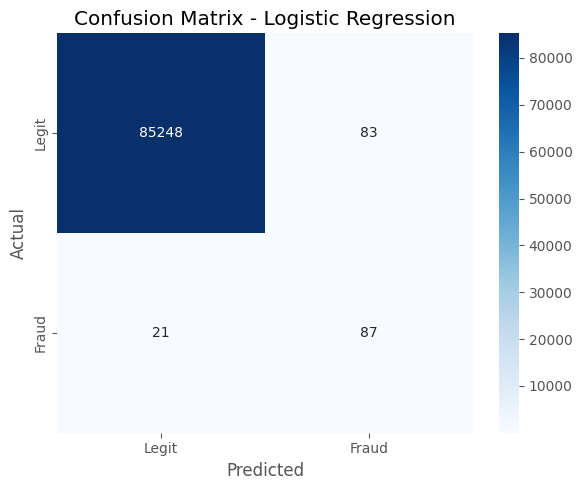


Classification Report:
              precision    recall  f1-score   support

           0      1.000     0.999     0.999     85331
           1      0.512     0.806     0.626       108

    accuracy                          0.999     85439
   macro avg      0.756     0.902     0.813     85439
weighted avg      0.999     0.999     0.999     85439



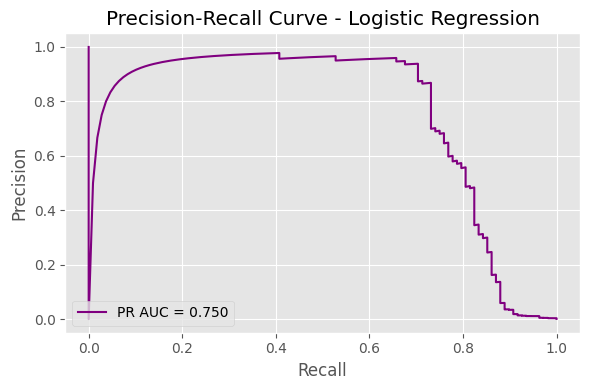


Random Forest - 5-Fold Cross-Validation F1 Scores: [0.7431694  0.91503268 0.83211679 0.73469388 0.84137931]
Average CV F1 Score: 0.813
Random Forest - Cost-sensitive threshold: 0.49, Min cost: 255
Fraud class metrics:
  Precision: 0.943
  Recall:    0.769
  F1-score:  0.847
  ROC-AUC:   0.961


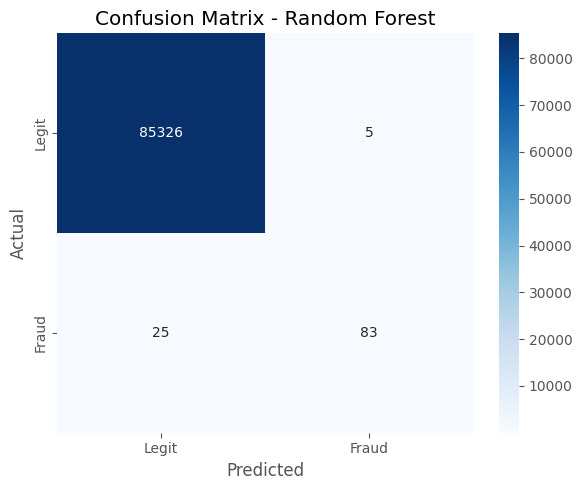


Classification Report:
              precision    recall  f1-score   support

           0      1.000     1.000     1.000     85331
           1      0.943     0.769     0.847       108

    accuracy                          1.000     85439
   macro avg      0.971     0.884     0.923     85439
weighted avg      1.000     1.000     1.000     85439



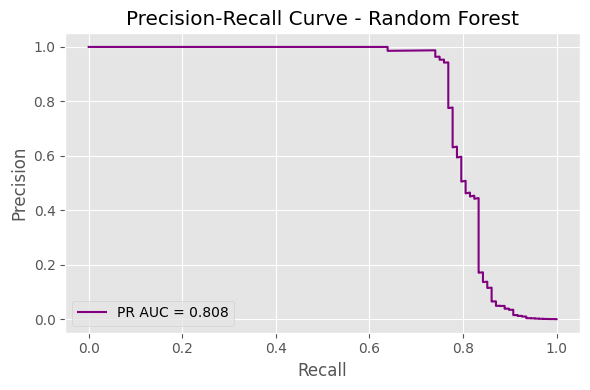


K-Nearest Neighbors - 5-Fold Cross-Validation F1 Scores: [0.75824176 0.88888889 0.71544715 0.66666667 0.68027211]
Average CV F1 Score: 0.742
K-Nearest Neighbors - Cost-sensitive threshold: 0.20, Min cost: 280
Fraud class metrics:
  Precision: 0.890
  Recall:    0.750
  F1-score:  0.814
  ROC-AUC:   0.903


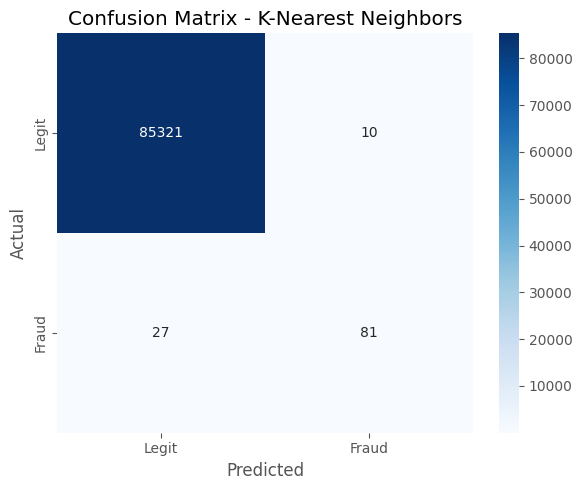


Classification Report:
              precision    recall  f1-score   support

           0      1.000     1.000     1.000     85331
           1      0.890     0.750     0.814       108

    accuracy                          1.000     85439
   macro avg      0.945     0.875     0.907     85439
weighted avg      1.000     1.000     1.000     85439



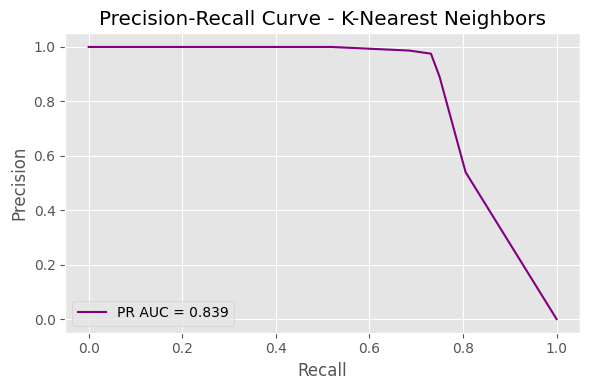

In [5]:
models = {
    'Logistic Regression': LogisticRegression(max_iter=2000, class_weight='balanced', random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_leaf=5, class_weight='balanced', random_state=42),
    'K-Nearest Neighbors': KNeighborsClassifier(n_neighbors=5, leaf_size=30, p=2)
}
# =========================
# Cost-Sensitive Threshold Tuning
# =========================

def cost_sensitive_threshold_search(model, X, y, cost_fn=10, cost_fp=1):
    y_scores = model.predict_proba(X)[:, 1]
    best_thresh, min_cost = 0.5, float('inf')
    thresholds = np.linspace(0, 1, 100)
    for thresh in thresholds:
        y_pred = (y_scores >= thresh).astype(int)
        cm = confusion_matrix(y, y_pred)
        tn, fp, fn, tp = cm.ravel()
        cost = cost_fn * fn + cost_fp * fp
        if cost < min_cost:
            min_cost = cost
            best_thresh = thresh
    return best_thresh, min_cost

# =========================
# Evaluation Function (Cross-Validation + PR AUC)
# =========================
def evaluate_model(model, X, y, X_test, y_test, name):
    model.fit(X, y)

    # 5-Fold Cross-Validation
    cv_scores = cross_val_score(model, X, y, cv=5, scoring='f1')
    print(f"\n{name} - 5-Fold Cross-Validation F1 Scores: {cv_scores}")
    print(f"Average CV F1 Score: {np.mean(cv_scores):.3f}")

    # Predict
    y_scores = model.predict_proba(X_test)[:, 1]
    best_thresh, min_cost = cost_sensitive_threshold_search(model, X_test, y_test)
    y_pred = (y_scores >= best_thresh).astype(int)

    # Metrics
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_scores)

    print(f"{name} - Cost-sensitive threshold: {best_thresh:.2f}, Min cost: {min_cost}")
    print("Fraud class metrics:")
    print(f"  Precision: {precision:.3f}")
    print(f"  Recall:    {recall:.3f}")
    print(f"  F1-score:  {f1:.3f}")
    print(f"  ROC-AUC:   {roc_auc:.3f}")

    # Confusion Matrix - Plot as Heatmap
    cm = confusion_matrix(y_test, y_pred)
    labels = ['Legit', 'Fraud']
    
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, digits=3))

    # Precision-Recall Curve with AUC
    precision_vals, recall_vals, _ = precision_recall_curve(y_test, y_scores)
    pr_auc = auc(recall_vals, precision_vals)

    plt.figure(figsize=(6, 4))
    plt.plot(recall_vals, precision_vals, label=f'PR AUC = {pr_auc:.3f}', color='purple')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve - {name}')
    plt.legend(loc='lower left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


for model_name, model in models.items():
    evaluate_model(model, X_train_scaled, y_train, X_test_scaled, y_test, model_name)
    

### 5. Error Analysis

In [6]:
rf = RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_leaf=5, class_weight='balanced', random_state=42)
rf.fit(X_train_scaled, y_train)
y_scores = rf.predict_proba(X_test_scaled)[:, 1]
best_thresh, _ = cost_sensitive_threshold_search(rf, X_test_scaled, y_test)
y_pred = (y_scores >= best_thresh).astype(int)

false_negatives_idx = (y_test.values == 1) & (y_pred == 0)
print("\nFalse negatives (missed frauds):")
print(test_data[false_negatives_idx])



False negatives (missed frauds):
            Time        V1        V2        V3        V4        V5        V6  \
204079  135102.0  1.862102 -0.124052 -1.989752  0.382609  0.473032 -0.674517   
213091  139107.0 -4.666500 -3.952320  0.206094  5.153525  5.229469  0.939040   
214777  139816.0 -0.395582 -0.751792 -1.984666 -0.203459  1.903967 -1.430289   
215952  140293.0  0.951025  3.252926 -5.039105  4.632411  3.014501 -1.349570   
219025  141565.0  0.114965  0.766762 -0.494132  0.116772  0.868169 -0.477982   
219887  141925.0  0.120301  1.974141 -0.434087  5.390793  1.289684  0.280590   
222418  142961.0  0.457845  1.373769 -0.488926  2.805351  1.777386  0.100492   
229727  146026.0  1.894036  1.905806 -3.515730  4.508913  2.044466 -1.420468   
231978  146998.0 -2.064240  2.629739 -0.748406  0.694992  0.418178  1.392520   
238466  149676.0  1.833191  0.745333 -1.133009  3.893556  0.858164  0.910235   
239501  150139.0 -6.682832 -2.714268 -5.774530  1.449792 -0.661836 -1.148650   
240222

### 6. Feature Importance Analysis

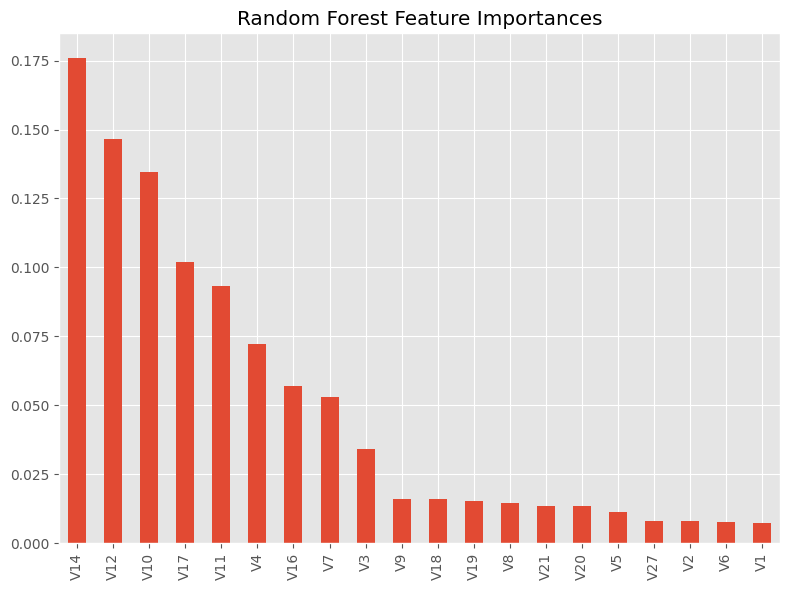

In [7]:
importances = rf.feature_importances_
feat_imp = pd.Series(importances, index=selected_features).sort_values(ascending=False)
plt.figure(figsize=(8, 6))
feat_imp.plot(kind='bar')
plt.title("Random Forest Feature Importances")
plt.tight_layout()
plt.show()
